# **Executive-PGP in Data Science from IIIT Bangalore | Upgrad | DSC43 Batch**

### **SUBMITTED BY**:

**Gurpreet Kaur** : Gurpreetkaurjethrap@gmail.com

## **Deep Learning Course Project - Gesture Recognition**

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

The hardware and software to capture and take action based on the gestures already exists with the manufacturer, our focus will be on `Recognising the Gestures`.

## Data
- The data we have been provided with to train our model consists of images / frames taken in a sequence (videos that are already broken down into images) for various individuals showing the above mentioned hand gestures.  
- The data is labelled with the different classes (gestures) that need to be identified.

## Approach
To do this, we will be using `Deep Learning`. Specifically, we will be trying two approaches:
- Approach 1: 3D CNN Model  
- Approach 2: A CNN + RNN Model

In [1]:
# Downgrading the module scipy to leverage the functionality of the imread and imresize
!pip install scipy==1.1.0 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 28.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
woodwork 0.16.4 requires scipy>=1.4.0, but you have scipy 1.1.0 which is incompatible.
tsfresh 0.20.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
tpot 0.11.7 requires scipy>=1.3.1, but you have scipy 1.1.0 which is incompatible.
stumpy 1.11.1 requires scipy>=1.5, but you have scipy 1.1.0 which is incompatible.
statsmodels 0.13.5 requires scipy<1.8,>=1.3; python_version == "3.7", but you have scipy 1.1.0 which is incompatible.
statsmodels 0.13.5 requires scipy>=1.3; (python_version > "3.9" or platform_system != "Windows" or platform_machine != "x86") and

In [2]:
# Importing the necessary libraries

import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
import cv2
import matplotlib.pyplot as plt
#% matplotlib inline

In [5]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In [6]:
project_folder='/kaggle/input/gesture-recognition'

In [7]:
train_doc = np.random.permutation(open('../input/gesture-recognition/train.csv').readlines())
val_doc = np.random.permutation(open('../input/gesture-recognition/val.csv').readlines())
batch_size = 64

### Plotting

In [8]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    # Initialising the paths where project data resides
    
    def initialize_path(self,project_folder):
        #data paths
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        #data paths
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        #Directory of images
        self.train_path = project_folder + '/' + 'train'
        #Directory of images
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    
  
  # initialising the image properties    
    #Data set creation properties
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3 #R,G,B
        self.num_classes=5 #Unique Gestures
        self.total_frames=30   #Frames to check for actions
        #Another options is check movements every 2 seconds
        #Frame every two seconds

  # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        #configurable 30
        self.frames_to_sample=frames_to_sample
        #Default 20
        self.batch_size=batch_size
        #Default 20
        self.num_epochs=num_epochs
           

        
    # The generator function : MOST IMPORTANT PART   
    #batches of data
    
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            #Randomly permute a sequence, or return a permuted range.
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
             #within the folder batches of 30 files
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# **MODEL**
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

## **Sample Model**

In [11]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

### Sample Cropping

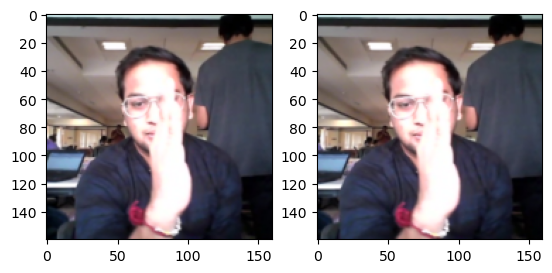

In [13]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [14]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [15]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.6621095314621925 Gigs


### So lets trade-off between these parameters

### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

**EXPERIMENT-1**

In [16]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.5468 - categorical_accuracy: 0.4238
Epoch 1: val_loss improved from inf to 2.63019, saving model to model_init_2023-03-1600_21_26.226412/model-00001-1.54676-0.42383-2.63019-0.21000.h5
34/34 [==============================] - 258s 7s/step - loss: 1.5468 - categorical_accuracy: 0.4238 - val_loss: 2.6302 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.0841 - categorical_accuracy: 0.5641
Epoch 2: val_loss did not improve from 2.63019
34/34 [==============================] - 118s 4s/step - loss: 1.0841 - categorical_accuracy: 0.5641 - val_loss: 3.9686 - val_categorical_accuracy: 0.2500 - lr: 0.0010


**EXPERIMENT-2**

In [17]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.7188 - categorical_accuracy: 0.3741
Epoch 1: val_loss improved from inf to 11.76938, saving model to model_init_2023-03-1600_27_48.634496/model-00001-1.71879-0.37406-11.76938-0.16000.h5
45/45 [==============================] - 144s 3s/step - loss: 1.7188 - categorical_accuracy: 0.3741 - val_loss: 11.7694 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.1058 - categorical_accuracy: 0.5641
Epoch 2: val_loss did not improve from 11.76938
45/45 [==============================] - 142s 3s/step - loss: 1.1058 - categorical_accuracy: 0.5641 - val_loss: 24.9846 - val_categorical_accuracy: 0.1500 - lr: 0.0010


**EXPERIMENT-3**

In [18]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6391 - categorical_accuracy: 0.3831
Epoch 1: val_loss improved from inf to 3.02839, saving model to model_init_2023-03-1600_32_36.784645/model-00001-1.63912-0.38311-3.02839-0.23000.h5
23/23 [==============================] - 76s 3s/step - loss: 1.6391 - categorical_accuracy: 0.3831 - val_loss: 3.0284 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.0246 - categorical_accuracy: 0.6109
Epoch 2: val_loss did not improve from 3.02839
23/23 [==============================] - 82s 4s/step - loss: 1.0246 - categorical_accuracy: 0.6109 - val_loss: 4.6083 - val_categorical_accuracy: 0.2800 - lr: 0.0010


## Conclusions:
- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution 160*160, 120*120 according the model performance


# **Model 1**
### Base Model - Batch Size = 40 and No. of Epochs = 15

In [19]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_17 (Activation)  (None, 10, 80, 80, 32)   

In [21]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.7158 - categorical_accuracy: 0.4012
Epoch 1: val_loss improved from inf to 1.47752, saving model to model_init_2023-03-1600_36_02.835712/model-00001-1.71581-0.40121-1.47752-0.37000.h5
17/17 [==============================] - 101s 6s/step - loss: 1.7158 - categorical_accuracy: 0.4012 - val_loss: 1.4775 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.9904 - categorical_accuracy: 0.6109
Epoch 2: val_loss did not improve from 1.47752
17/17 [==============================] - 96s 6s/step - loss: 0.9904 - categorical_accuracy: 0.6109 - val_loss: 2.7320 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.6495 - categorical_accuracy: 0.7406
Epoch 3: val_loss did not improve from 1.47752
17/17 [==============================] - 93s 6s/step - loss: 0.6495 - categorical_acc

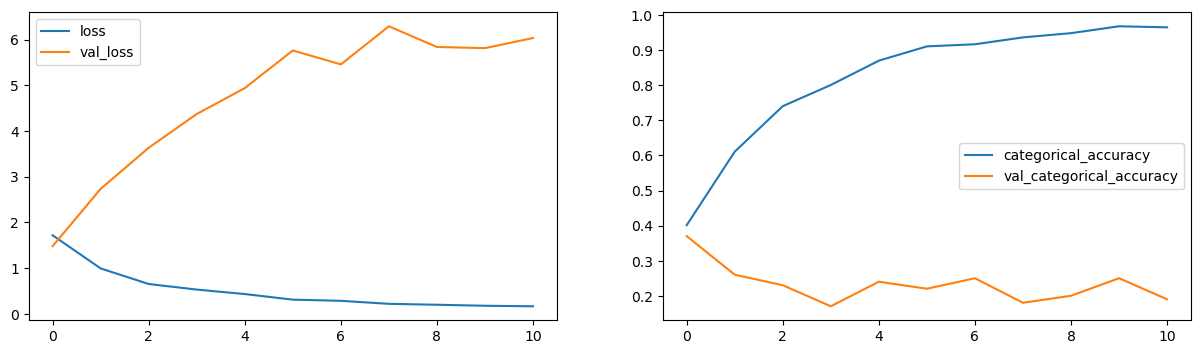

In [22]:
plot(history_model1)

### Result Model 1:

- Model is clearly Overfitting!!
- Training Accuracy: 0.96 & Validation Accuracy: 0.19
- Let’s add some Dropout Layers to increase performance


# **Model 2**  
### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [23]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_21 (Activation)  (None, 10, 80, 80, 32)   

In [24]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8859 - categorical_accuracy: 0.3989
Epoch 1: val_loss improved from inf to 3.38871, saving model to model_init_2023-03-1600_53_31.320157/model-00001-1.88594-0.39894-3.38871-0.22000.h5
34/34 [==============================] - 189s 6s/step - loss: 1.8859 - categorical_accuracy: 0.3989 - val_loss: 3.3887 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2763 - categorical_accuracy: 0.5716
Epoch 2: val_loss did not improve from 3.38871
34/34 [==============================] - 168s 5s/step - loss: 1.2763 - categorical_accuracy: 0.5716 - val_loss: 5.4257 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1713 - categorical_accuracy: 0.5943
Epoch 3: val_loss did not improve from 3.38871
34/34 [==============================] - 166s 5s/step - loss: 1.1713 - categorical_a

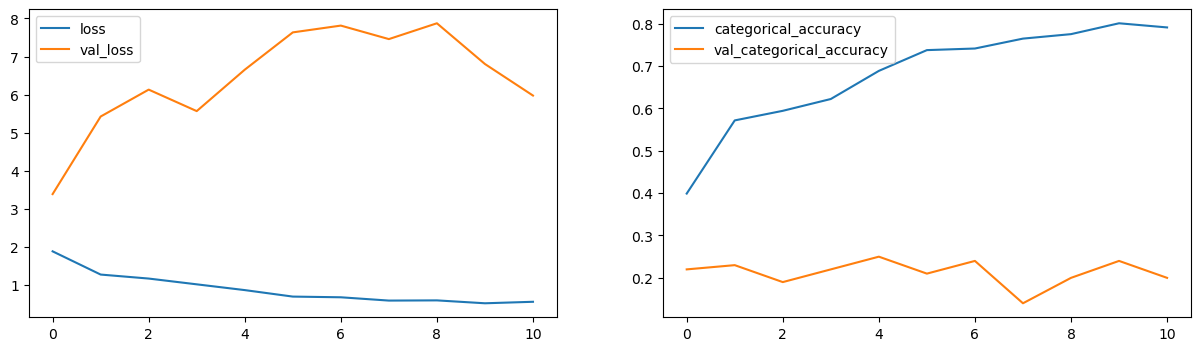

In [25]:
plot(history_model2)

### Result Model 2:
- We can see  val_loss did not improve from 3.38 so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 11/25!! good job earlystopping ;)
- Best weights save automatically. The validation accuracy of 20% and training accuracy of 79% shows overfitting again.
- Next we will try to reduce the filter size and image resolution and see if get better results. 
- Moreover since we see minor oscillations  in loss, let's try lowering the learning rate to 0.0002

# **Model 3** 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 30 and No. of Epochs = 25

In [26]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_25 (Activation)  (None, 8, 60, 60, 32)    

In [28]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.3310 - categorical_accuracy: 0.2873
Epoch 1: val_loss improved from inf to 1.81286, saving model to model_init_2023-03-1601_24_24.461984/model-00001-2.33100-0.28733-1.81286-0.17000.h5
23/23 [==============================] - 138s 6s/step - loss: 2.3310 - categorical_accuracy: 0.2873 - val_loss: 1.8129 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5428 - categorical_accuracy: 0.4630
Epoch 2: val_loss did not improve from 1.81286
23/23 [==============================] - 138s 6s/step - loss: 1.5428 - categorical_accuracy: 0.4630 - val_loss: 2.8425 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.3104 - categorical_accuracy: 0.5498
Epoch 3: val_loss did not improve from 1.81286
23/23 [==============================] - 122s 6s/step - loss: 1.3104 - categ

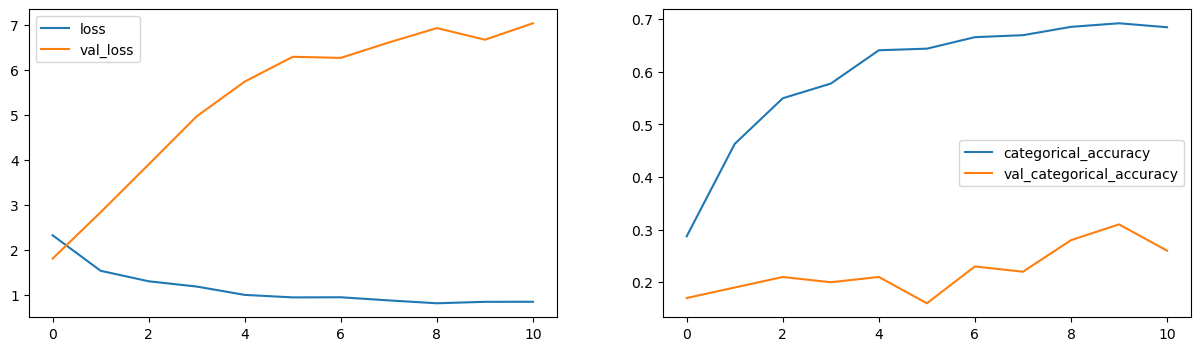

In [29]:
plot(history_model3)

### Result Model 3:

- Model is Overfitting but bit improvement!
- Training Accuracy: 0.68 & Validation Accuracy: 0.26
- We can see val_loss did not improve from 1.81 so earlystopping stops the epoch automatically!
- Last Epoch stop on 11/25!! good job earlystopping ;)
- Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

# **Model 4** 
### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [30]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_29 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_29 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_43 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [32]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0085 - categorical_accuracy: 0.3575
Epoch 1: val_loss improved from inf to 2.00712, saving model to model_init_2023-03-1601_46_20.779092/model-00001-2.00847-0.35747-2.00712-0.16000.h5
34/34 [==============================] - 129s 4s/step - loss: 2.0085 - categorical_accuracy: 0.3575 - val_loss: 2.0071 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5618 - categorical_accuracy: 0.4668
Epoch 2: val_loss did not improve from 2.00712
34/34 [==============================] - 141s 4s/step - loss: 1.5618 - categorical_accuracy: 0.4668 - val_loss: 3.4045 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3640 - categorical_accuracy: 0.5377
Epoch 3: val_loss did not improve from 2.00712
34/34 [==============================] - 129s 4s/step - loss: 1.3640 - categorical_a

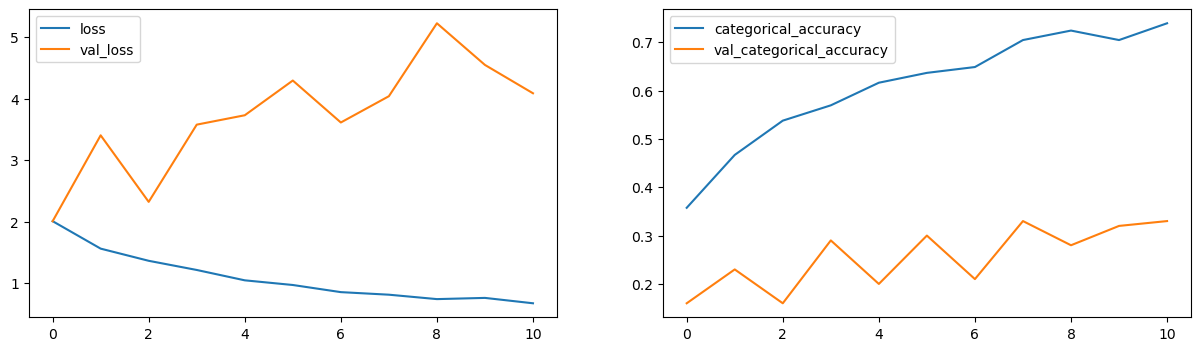

In [33]:
plot(history_model4)

### Result Model 4:

- Model is Overfitting but bit improvement!
- Training Accuracy: 0.73 & Validation Accuracy: 0.33
- We can see val_loss did not improve from 2.00 so earlystopping stops the epoch automatically!
- Last Epoch stop on 11/25!! good job earlystopping ;)
- With more layers we dont see much performance improvement.
- Let's try adding dropouts at the convolution layers.

# **Model 5** 
### Adding dropout at convolution layers

In [34]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_52 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_37 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_37 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_53 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [36]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.8527 - categorical_accuracy: 0.3658
Epoch 1: val_loss improved from inf to 1.97299, saving model to model_init_2023-03-1602_10_30.541850/model-00001-1.85272-0.36576-1.97299-0.21000.h5
34/34 [==============================] - 163s 5s/step - loss: 1.8527 - categorical_accuracy: 0.3658 - val_loss: 1.9730 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.3771 - categorical_accuracy: 0.4970
Epoch 2: val_loss did not improve from 1.97299
34/34 [==============================] - 163s 5s/step - loss: 1.3771 - categorical_accuracy: 0.4970 - val_loss: 2.5341 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.1118 - categorical_accuracy: 0.5882
Epoch 3: val_loss did not improve from 1.97299
34/34 [==============================] - 166s 5s/step - loss: 1.1118 - categorical_a

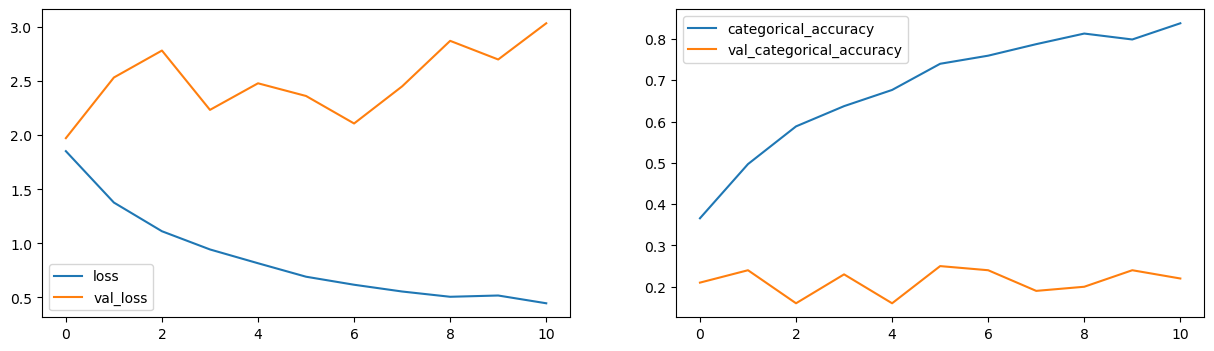

In [37]:
plot(history_model5)

### Results Model 5:
- Training Accuracy: 0.83 & Validation Accuracy: 0.23        

 __Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.__

##### All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# **Model 6** 
### Reducing the number of parameters

In [11]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 100, 100, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 100, 100, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 50, 50, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 50, 50, 32)     0

In [14]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7426 - categorical_accuracy: 0.3771
Epoch 1: val_loss improved from inf to 1.89526, saving model to model_init_2023-03-1604_04_23.477079/model-00001-1.74257-0.37707-1.89526-0.16000.h5
34/34 [==============================] - 163s 5s/step - loss: 1.7426 - categorical_accuracy: 0.3771 - val_loss: 1.8953 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1778 - categorical_accuracy: 0.5626
Epoch 2: val_loss did not improve from 1.89526
34/34 [==============================] - 110s 3s/step - loss: 1.1778 - categorical_accuracy: 0.5626 - val_loss: 2.6786 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0092 - categorical_accuracy: 0.6259
Epoch 3: val_loss did not improve from 1.89526
34/34 [==============================] - 102s 3s/step - loss: 1.0092 - catego

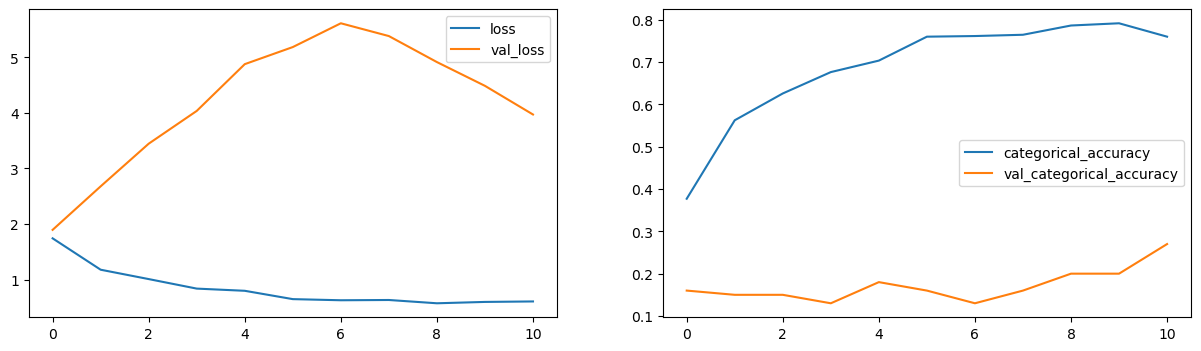

In [15]:
plot(history_model6)

### Results Model 6:

- Model is Overfitting but bit improvement!
- Training Accuracy: 0.76 & Validation Accuracy: 0.27
- We can see val_loss did not improve from 1.89 so earlystopping stops the epoch automatically!
- Last Epoch stop on 11/25!! good job earlystopping ;)
- Overfitting reduced, but validation accuracy low.  Let's try to reduce the parameters. 

# **Model 7**

###  Reducing the number of parameters again

In [16]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_4 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_5 (Activation)   (None, 8, 60, 60, 32)    

In [18]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7875 - categorical_accuracy: 0.3228
Epoch 1: val_loss improved from inf to 1.75045, saving model to model_init_2023-03-1604_24_39.656445/model-00001-1.78746-0.32278-1.75045-0.21000.h5
34/34 [==============================] - 110s 3s/step - loss: 1.7875 - categorical_accuracy: 0.3228 - val_loss: 1.7504 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2425 - categorical_accuracy: 0.5128
Epoch 2: val_loss did not improve from 1.75045
34/34 [==============================] - 110s 3s/step - loss: 1.2425 - categorical_accuracy: 0.5128 - val_loss: 2.0362 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1156 - categorical_accuracy: 0.5762
Epoch 3: val_loss did not improve from 1.75045
34/34 [==============================] - 118s 4s/step - loss: 1.1156 - catego

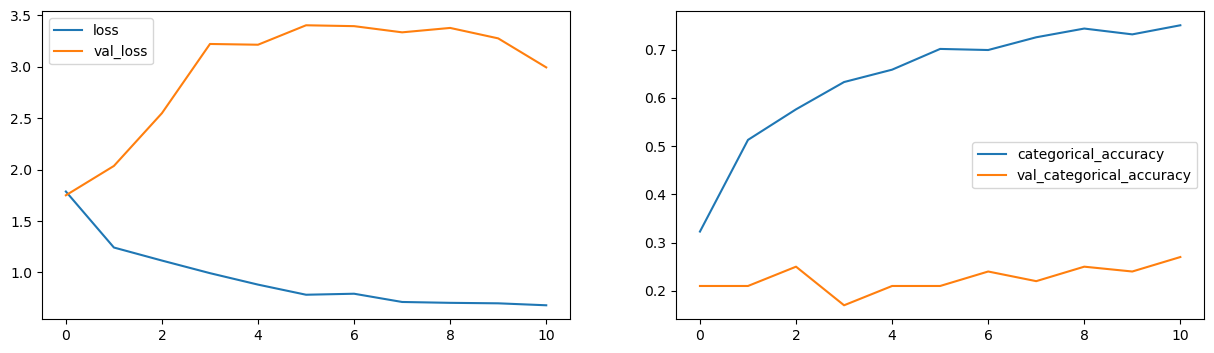

In [19]:
plot(history_model7)

### Results Model 7:

- Model is Overfitting but bit improvement!
- Training Accuracy: 0.75 & Validation Accuracy: 0.27
- We can see val_loss did not improve from 1.75 so earlystopping stops the epoch automatically!
- Last Epoch stop on 11/25!! good job earlystopping ;)
- Overfitting reduced, but validation accuracy low.  Let’s switch to CNN+LSTM.

# **Model 8 - CNN- LSTM Model**

In [20]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [22]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4109 - categorical_accuracy: 0.3620
Epoch 1: val_loss improved from inf to 1.65419, saving model to model_init_2023-03-1604_45_04.755967/model-00001-1.41088-0.36199-1.65419-0.11000.h5
34/34 [==============================] - 159s 5s/step - loss: 1.4109 - categorical_accuracy: 0.3620 - val_loss: 1.6542 - val_categorical_accuracy: 0.1100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1994 - categorical_accuracy: 0.5023
Epoch 2: val_loss did not improve from 1.65419
34/34 [==============================] - 121s 4s/step - loss: 1.1994 - categorical_accuracy: 0.5023 - val_loss: 2.4832 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.0822 - categorical_accuracy: 0.5452
Epoch 3: val_loss did not improve from 1.65419
34/34 [==============================] - 121s 4s/step - loss: 1.0822 - categorical_a

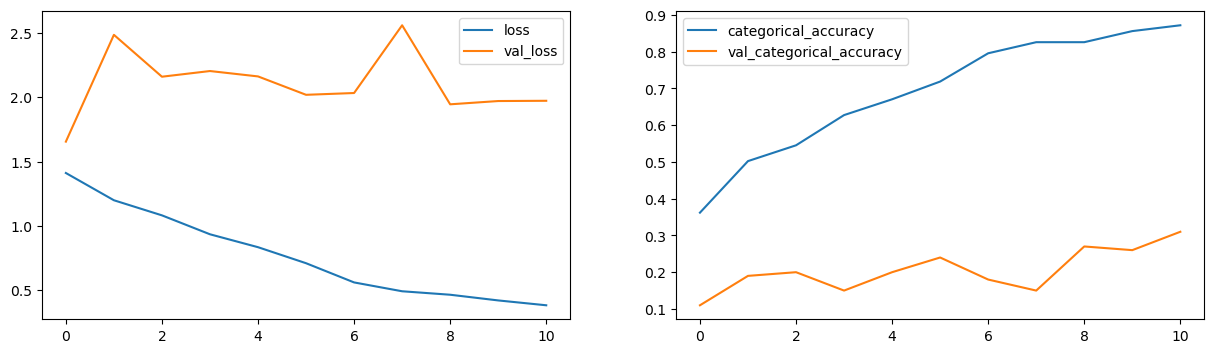

In [23]:
plot(history_model8)

 ### Results Model 8(CNN - LSTM Model):

- Performance Improved.
- Training Accuracy: 0.87 & Validation Accuracy: 0.31
- We can see val_loss did not improve from 1.65 so earlystopping stops the epoch automatically!
- Last Epoch stop on 11/25!! good job earlystopping ;)
- Overfitting reduced, but validation accuracy low. 

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some **Data Augmentation** & check the model performance.

In [24]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

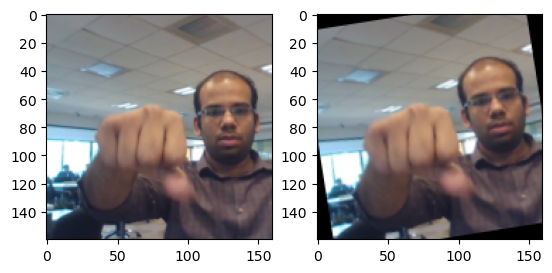

In [25]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

# **Model 9 with Augmentation**
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [26]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_17 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 10, 80, 80, 32)   

In [28]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 2.0437 - categorical_accuracy: 0.3627
Epoch 1: saving model to model_init_2023-03-1605_08_47.815874/model-00001-2.04367-0.36275-2.54861-0.16000.h5
34/34 [==============================] - 181s 5s/step - loss: 2.0437 - categorical_accuracy: 0.3627 - val_loss: 2.5486 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5410 - categorical_accuracy: 0.4502
Epoch 2: saving model to model_init_2023-03-1605_08_47.815874/model-00002-1.54103-0.45023-4.25721-0.13000.h5
34/34 [==============================] - 161s 5s/step - loss: 1.5410 - categorical_accuracy: 0.4502 - val_loss: 4.2572 - val_categorical_accuracy: 0.1300 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3227 - categorical_accuracy: 0.5400
Epoch 3: saving model to model_init_2023-03-1605_08_47.815874/model-00003-1.32271-0.53997-5.41671-0.

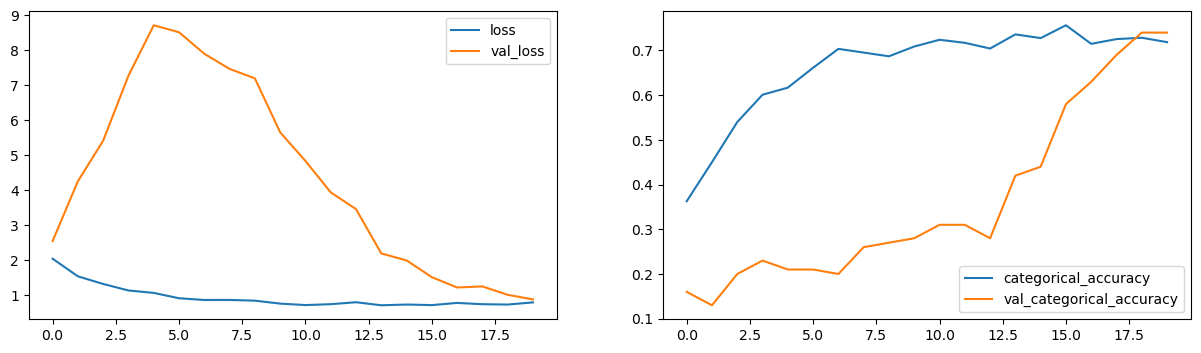

In [29]:
plot(history_model9)

### Result Model 9 Using Data Augmentation with Conv3D:
- Performance Increased.
- **Using Data Augmentation, Overfitting Issue Resolved!**
- **Best Model So Far!**


# **Model 10 with Augmentation**
### (2,2,2) Filter  & 120x120 Image resolution - similar to Model 3

In [30]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_23 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_13 (Activation)  (None, 8, 60, 60, 32)    

In [32]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.0903 - categorical_accuracy: 0.3333
Epoch 1: saving model to model_init_2023-03-1606_00_58.439011/model-00001-2.09029-0.33333-2.06535-0.16000.h5
23/23 [==============================] - 113s 5s/step - loss: 2.0903 - categorical_accuracy: 0.3333 - val_loss: 2.0654 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.5480 - categorical_accuracy: 0.4774
Epoch 2: saving model to model_init_2023-03-1606_00_58.439011/model-00002-1.54800-0.47738-3.01822-0.14000.h5
23/23 [==============================] - 105s 5s/step - loss: 1.5480 - categorical_accuracy: 0.4774 - val_loss: 3.0182 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2248 - categorical_accuracy: 0.5437
Epoch 3: saving model to model_init_2023-03-1606_00_58.439011/model-00003-1.22484-0.54374-4.37844-0.

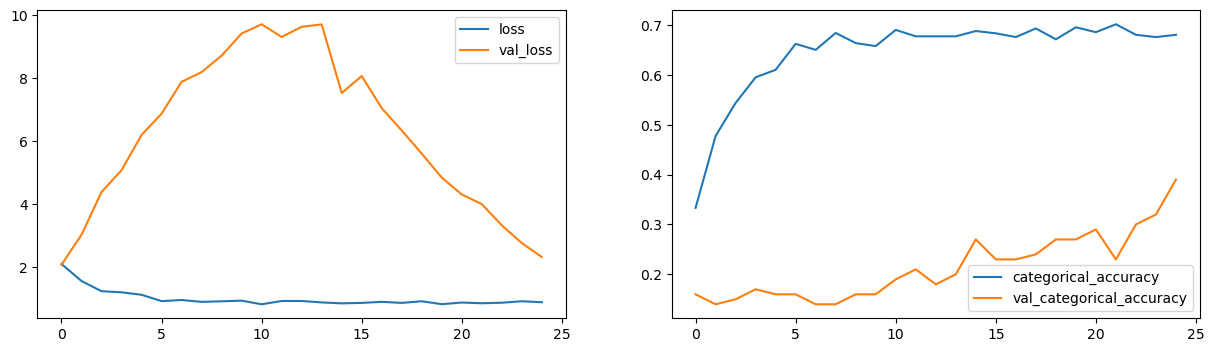

In [33]:
plot(history_model10)

### Result Model 10:

- Training Accuracy        : 0.68  Validation Accuracy    : 0.40
- (2, 2, 2) Filter & 120 x 120 image resolution. Increase epoch count. Network is generalizing well.
- Parameters Reduced but Performance too Reduced.


# **Model 11 with Augmentation**
### Adding more layers - Similar to model 4

In [34]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_29 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_17 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [36]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.2698 - categorical_accuracy: 0.2994
Epoch 1: saving model to model_init_2023-03-1606_45_26.771722/model-00001-2.26985-0.29940-2.14333-0.16000.h5
34/34 [==============================] - 115s 3s/step - loss: 2.2698 - categorical_accuracy: 0.2994 - val_loss: 2.1433 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6260 - categorical_accuracy: 0.4517
Epoch 2: saving model to model_init_2023-03-1606_45_26.771722/model-00002-1.62602-0.45173-2.83874-0.16000.h5
34/34 [==============================] - 107s 3s/step - loss: 1.6260 - categorical_accuracy: 0.4517 - val_loss: 2.8387 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3615 - categorical_accuracy: 0.5128
Epoch 3: saving model to model_init_2023-03-1606_45_26.771722/model-00003-1.36150-0.51282-3.19726-0.

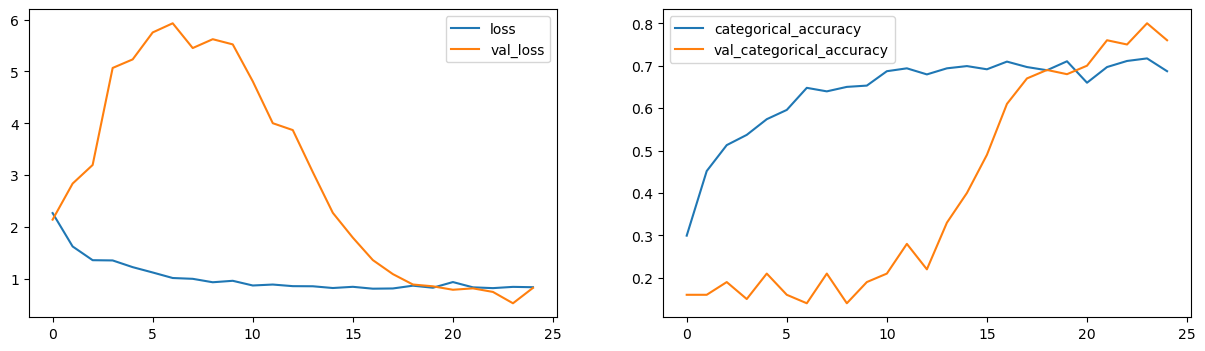

In [37]:
plot(history_model11)

### Result Model 11:

- Adding more layers.
- **Increased Performance Again with “Least Parameters”** 
- Data Augmentation Solves Overfitting Issue.
- Training Accuracy        : 0.71  Validation Accuracy    : 0.75 (Epoc 23/25 Best Accuracy)



# **Model 12 with Augmentation**
### Adding dropouts - Similar to Model 5

In [38]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_39 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_25 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_40 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [40]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0859 - categorical_accuracy: 0.2986
Epoch 1: saving model to model_init_2023-03-1607_34_37.557592/model-00001-2.08593-0.29864-2.24788-0.21000.h5
34/34 [==============================] - 120s 4s/step - loss: 2.0859 - categorical_accuracy: 0.2986 - val_loss: 2.2479 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5608 - categorical_accuracy: 0.4284
Epoch 2: saving model to model_init_2023-03-1607_34_37.557592/model-00002-1.56075-0.42836-3.19145-0.22000.h5
34/34 [==============================] - 115s 3s/step - loss: 1.5608 - categorical_accuracy: 0.4284 - val_loss: 3.1915 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.3964 - categorical_accuracy: 0.4872
Epoch 3: saving model to model_init_2023-03-1607_34_37.557592/model-00003-1.39642-0.48718-4.40043-0.

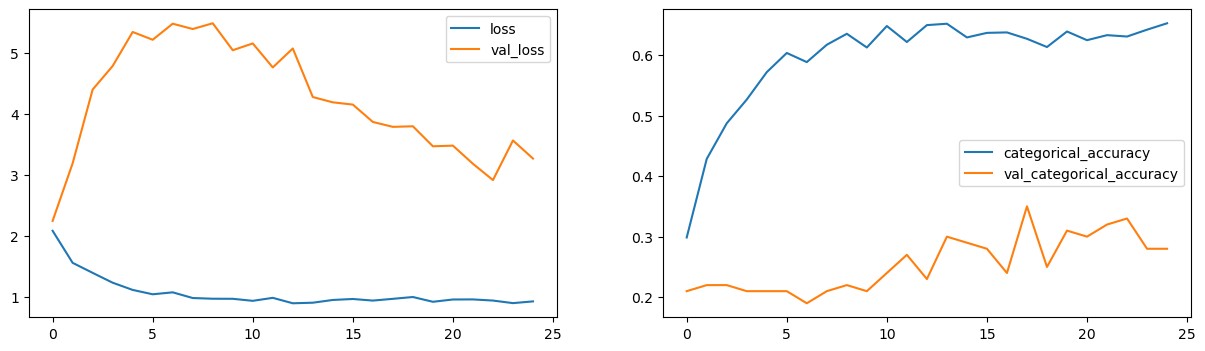

In [41]:
plot(history_model12)

### Result Model 12:
- Model is overfitting badly !!
- Training Accuracy        : 0.63  Validation Accuracy    : 0.33 (Epoc 23/25)
- On Adding More layers of dropout layers decreases Performance Again.

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [42]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [43]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_49 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_33 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_33 (Activation)  (None, 8, 50, 50, 32)    

In [44]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7880 - categorical_accuracy: 0.3537
Epoch 1: saving model to model_init_2023-03-1608_22_04.136269/model-00001-1.78797-0.35370-1.86276-0.21000.h5
34/34 [==============================] - 100s 3s/step - loss: 1.7880 - categorical_accuracy: 0.3537 - val_loss: 1.8628 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2532 - categorical_accuracy: 0.5053
Epoch 2: saving model to model_init_2023-03-1608_22_04.136269/model-00002-1.25317-0.50528-2.06478-0.20000.h5
34/34 [==============================] - 104s 3s/step - loss: 1.2532 - categorical_accuracy: 0.5053 - val_loss: 2.0648 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.0621 - categorical_accuracy: 0.5897
Epoch 3: saving model to model_init_2023-03-1608_22_04.136269/model-00003-1.06213-0.58974-2.40251-0.1

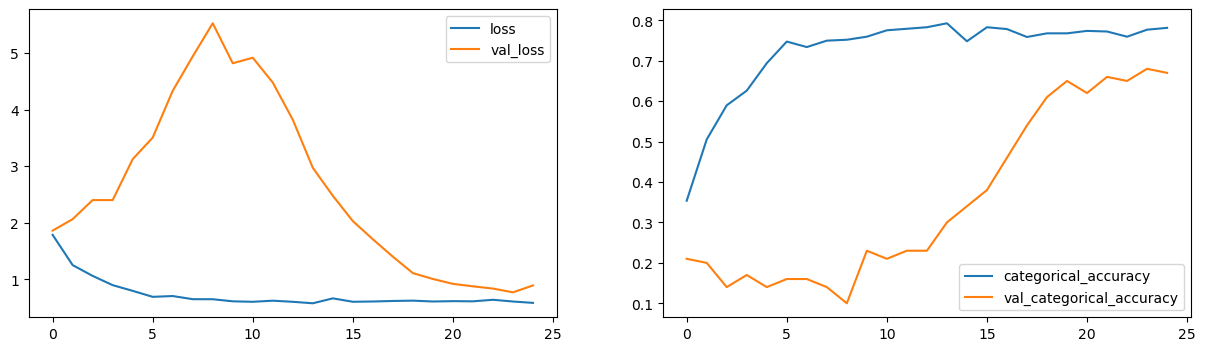

In [45]:
plot(history_model13)

### Result Model 13:

- After reducing network parameters, model’s performance is quite good.
- Overfitting Resolved.
- Training Accuracy        : 0.78  Validation Accuracy    : 0.67

# **Model 14 with Augmentation**
###  Reducing network parameters again - Similar to model 7

In [46]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_55 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_37 (Activation)  (None, 8, 60, 60, 32)    

In [48]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7927 - categorical_accuracy: 0.3288
Epoch 1: saving model to model_init_2023-03-1609_04_46.576963/model-00001-1.79269-0.32881-1.70682-0.22000.h5
34/34 [==============================] - 110s 3s/step - loss: 1.7927 - categorical_accuracy: 0.3288 - val_loss: 1.7068 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3284 - categorical_accuracy: 0.4910
Epoch 2: saving model to model_init_2023-03-1609_04_46.576963/model-00002-1.32844-0.49095-1.86501-0.19000.h5
34/34 [==============================] - 104s 3s/step - loss: 1.3284 - categorical_accuracy: 0.4910 - val_loss: 1.8650 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1135 - categorical_accuracy: 0.5709
Epoch 3: saving model to model_init_2023-03-1609_04_46.576963/model-00003-1.11354-0.57089-2.15362-0.2

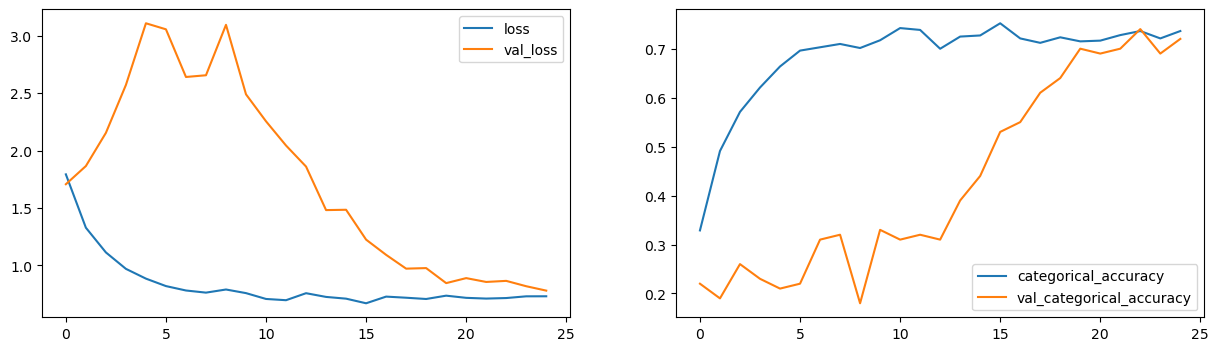

In [49]:
plot(history_model14)

### Result Model 14:

- Reduced Least network Parameters.
- **Performance Increased.**
- No Overfitting.
- Validation Accuracy Improved.
- **Best Model.**
- Training Accuracy: 0.73 , Validation Accuracy    : 0.74


# **Model 15 with Augmentation**
### CNN LSTM with GRU - Similar to Model 8

In [50]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [51]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32)  

In [52]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4592 - categorical_accuracy: 0.3808
Epoch 1: saving model to model_init_2023-03-1609_48_07.065581/model-00001-1.45922-0.38084-1.64090-0.21000.h5
34/34 [==============================] - 173s 5s/step - loss: 1.4592 - categorical_accuracy: 0.3808 - val_loss: 1.6409 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0592 - categorical_accuracy: 0.5747
Epoch 2: saving model to model_init_2023-03-1609_48_07.065581/model-00002-1.05918-0.57466-2.18392-0.19000.h5
34/34 [==============================] - 161s 5s/step - loss: 1.0592 - categorical_accuracy: 0.5747 - val_loss: 2.1839 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8531 - categorical_accuracy: 0.6817
Epoch 3: saving model to model_init_2023-03-1609_48_07.065581/model-00003-0.85310-0.68175-2.19768-0.

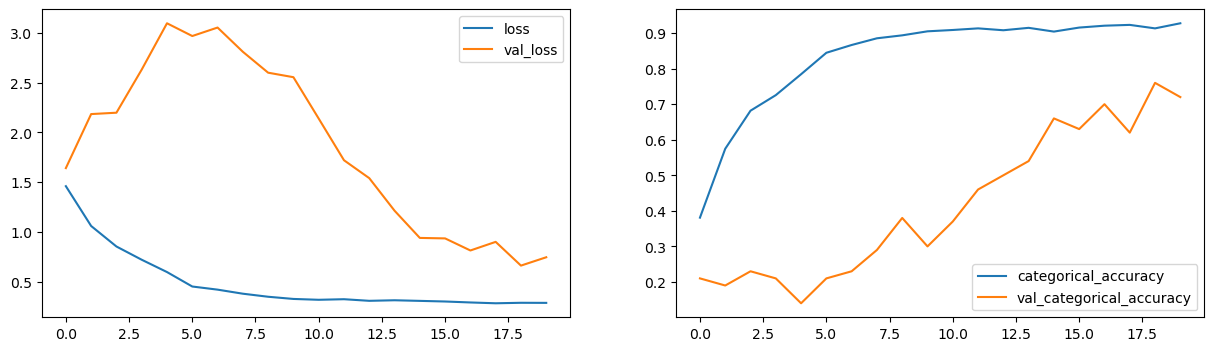

In [53]:
plot(history_model15)

### Result Model 15 (CNN LSTM GRU,Augmentation)

- We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy
- Training Accuracy        : 0.91  Validation Accuracy    : 0.76

# **Model 16 - Let us bring in Transfer Learning** !! :)
__(Optional)__

In [54]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. 

from keras.applications import mobilenet

In [55]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 0s 0us/step


In [56]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [57]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3595 - categorical_accuracy: 0.4118
Epoch 1: saving model to model_init_2023-03-1610_43_38.859760/model-00001-1.35952-0.41176-0.93616-0.66000.h5
133/133 [==============================] - 153s 1s/step - loss: 1.3595 - categorical_accuracy: 0.4118 - val_loss: 0.9362 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8990 - categorical_accuracy: 0.6448
Epoch 2: saving model to model_init_2023-03-1610_43_38.859760/model-00002-0.89896-0.64480-0.76895-0.69000.h5
133/133 [==============================] - 147s 1s/step - loss: 0.8990 - categorical_accuracy: 0.6448 - val_loss: 0.7690 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6943 - categorical_accuracy: 0.7278
Epoch 3: saving model to model_init_2023-03-1610_43_38.859760/model-00003-0.69429-0.72775-0.81121-

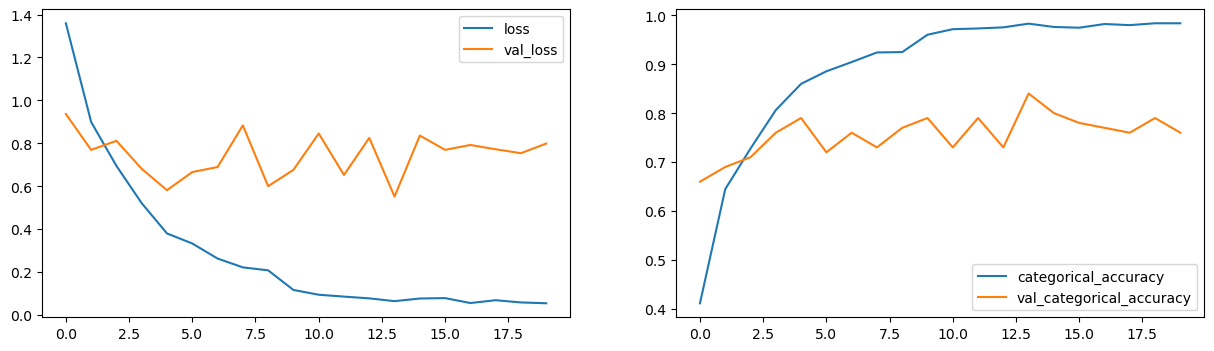

In [58]:
plot(history_model16)

### Result Model 16 (Using Transfer Learning):

- Performance Improved by using Transfer learning(Mobile Net) with reduced Batch Size.
- Overfitting Resolved.
- Training Accuracy        : 0.98  Validation Accuracy    : 0.84 (Epoc 14/20 best Accuracy)

- We are not training the mobilenet weights and we see validation accuracy not so good as expected. Let's train them as well and observe if there is performance improvement.

# **Model 17 - Transfer Learning with GRU and training all weights**
__(Optional)__

In [59]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [60]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [48]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2770 - categorical_accuracy: 0.4744
Epoch 1: saving model to model_init_2023-03-1613_47_07.814028/model-00001-1.27695-0.47436-0.69801-0.74000.h5
133/133 [==============================] - 169s 1s/step - loss: 1.2770 - categorical_accuracy: 0.4744 - val_loss: 0.6980 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.7365 - categorical_accuracy: 0.7225
Epoch 2: saving model to model_init_2023-03-1613_47_07.814028/model-00002-0.73653-0.72247-0.31061-0.92000.h5
133/133 [==============================] - 107s 809ms/step - loss: 0.7365 - categorical_accuracy: 0.7225 - val_loss: 0.3106 - val_categorical_accuracy: 0.9200 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4689 - categorical_accuracy: 0.8265
Epoch 3: saving model to model_init_2023-03-1613_47_07.814028/model-00003-0.46888-0.82655-0.397

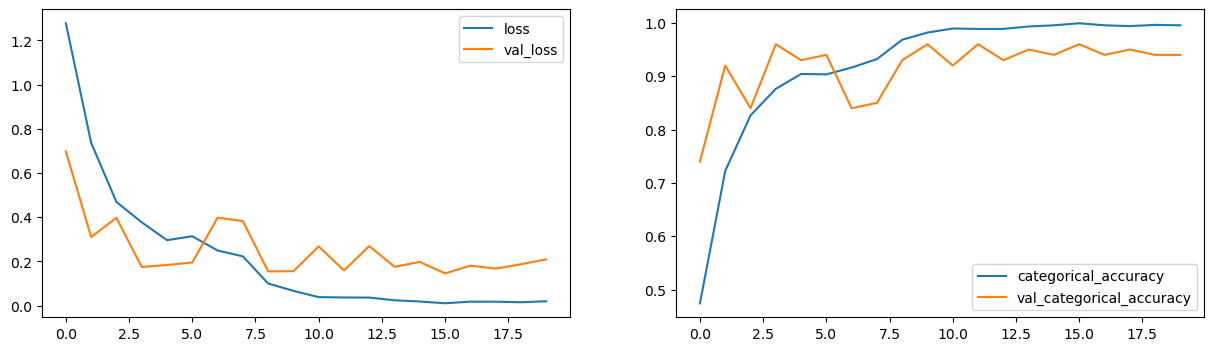

In [49]:
plot(history_model17)

## Model 17 Results - Using Transfer Learning with GRU and training all weights: 
### Awwwwwesome Results With 99.9% Training accuracy and 96% Validation Accuracy!!!! :)

#### Downloading Best Models having good performance from Kaggle

In [ ]:
# Downloading Best Models having good performance from Kaggle

# from IPython.display import FileLink
# FileLink(r'model_init_2023-03-1613_47_07.814028/model-00019-0.01565-0.99623-0.18739-0.94000.h5')
# FileLink(r'model_init_2023-03-1606_45_26.771722/model-00024-0.84722-0.71719-0.53095-0.80000.h5')

# **Loading Best Model and Testing**

## MODEL-1: CNN+LSTM Model Testing

In [40]:
import time
from keras.models import load_model
model = load_model('model_init_2023-03-1606_45_26.771722/model-00024-0.84722-0.71719-0.53095-0.80000.h5')

In [57]:
test_generator=ModelConv3D11()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [58]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [43]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 8s 8s/step
[3 1 2 1 4 3 1 3 1 2 4 1 0 1 2 3 4 2 1 4]


## MODEL-2: TRANSFER LEARNING WITH GRU MODEL TESTING

In [52]:
import time
from keras.models import load_model
model = load_model('model_init_2023-03-1613_47_07.814028/model-00019-0.01565-0.99623-0.18739-0.94000.h5')

In [54]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [55]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [56]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 1s 1s/step
[1 2 2 3 4]


#  **Consolidated Final Models**

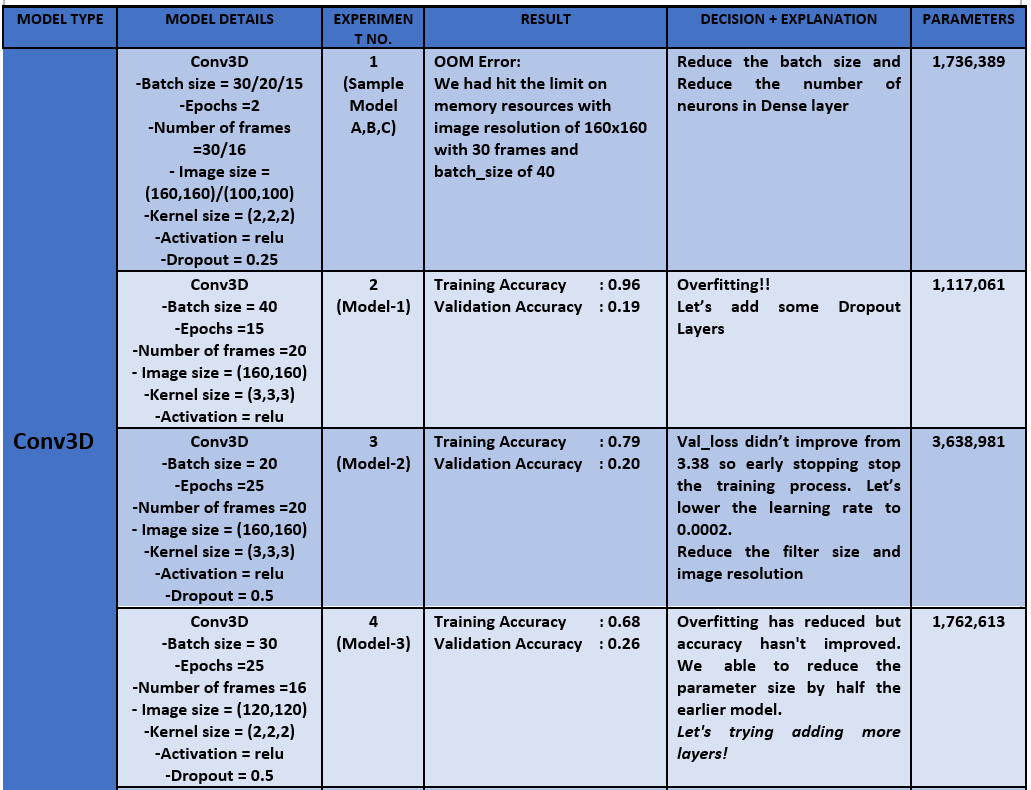
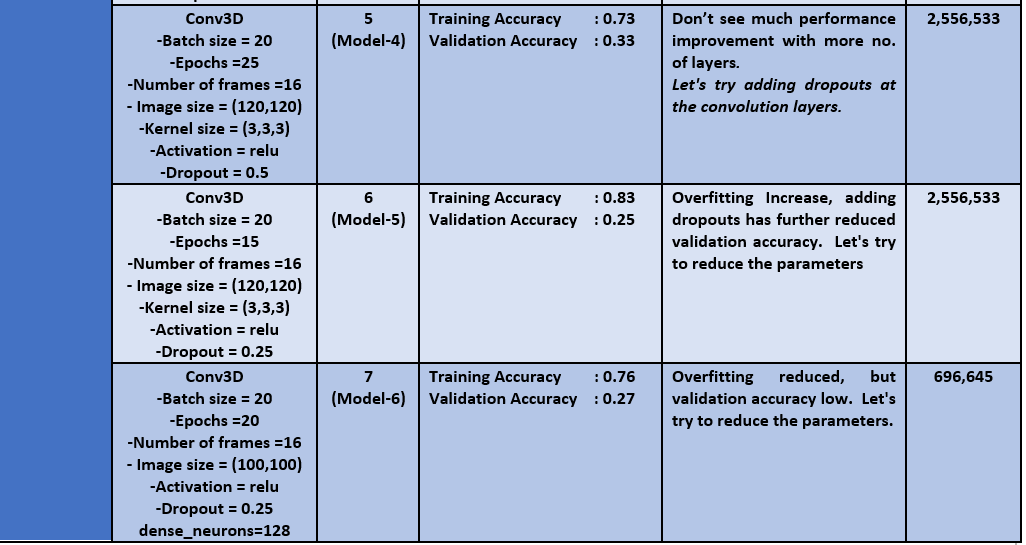
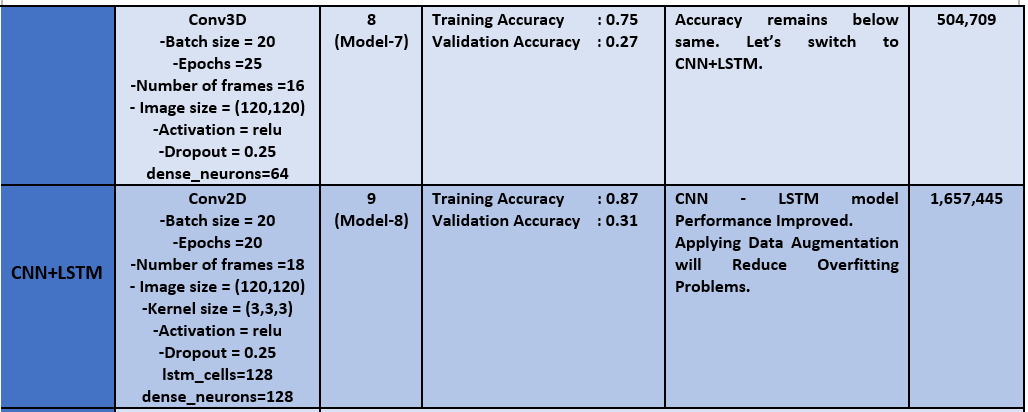
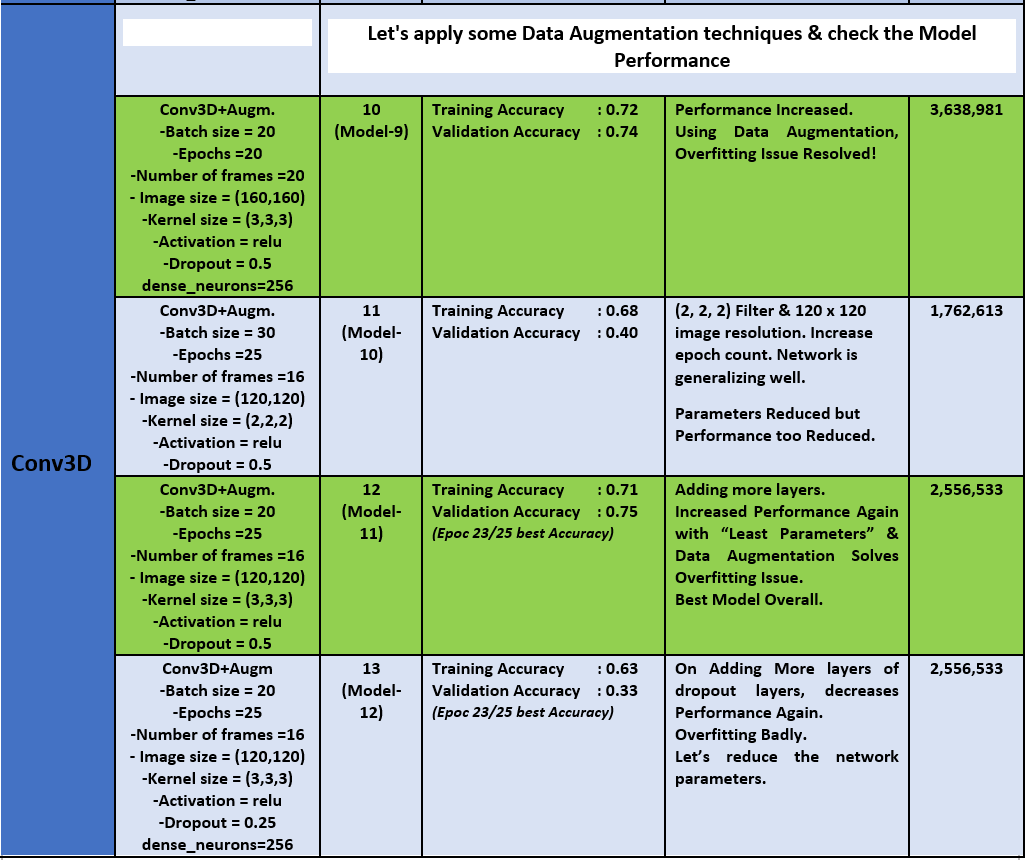
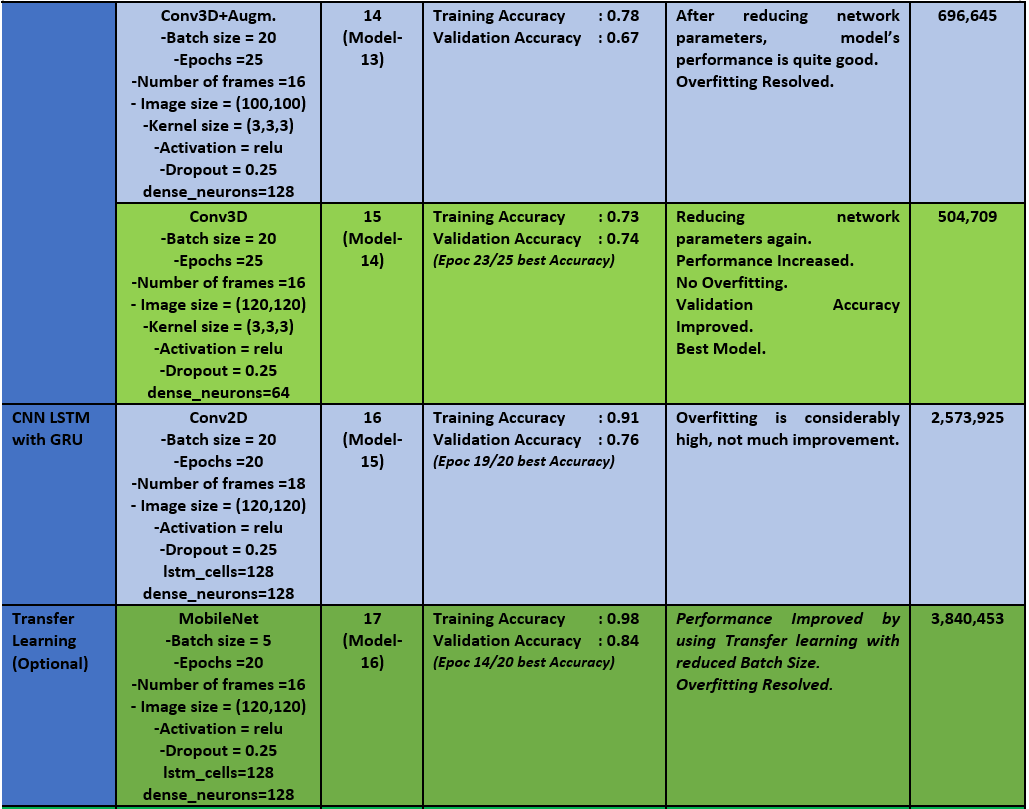
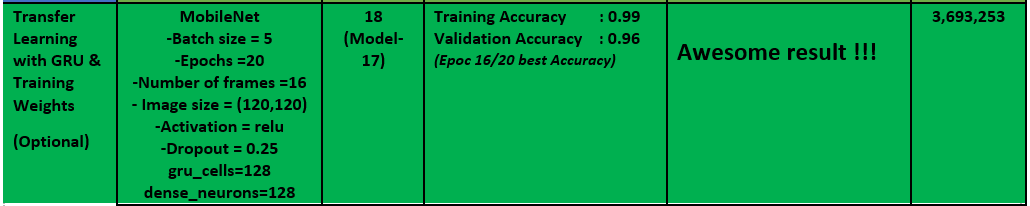

# **RESULTS**

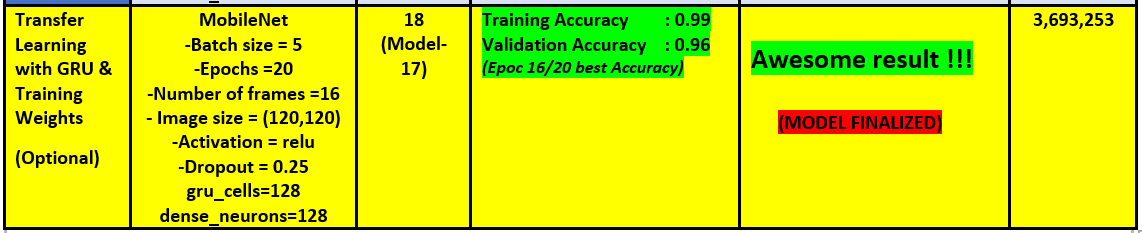

## After doing all the experiments, we finalized Model 17 - Transfer Learning with GRU & Training Weights, which performed Extremely well.
__Reason:__

__- AWESOME PERFORMANCE (Training Accuracy : 99%, Validation Accuracy : 96%)__

__- Performance Increased.  No Overfitting.  Validation Accuracy Improved Drastically.__

__- Number of Parameters(3,693,253)__


__The best weights of CONV3D+GRU(TL): model-00019-0.01565-0.99623-0.18739-0.94000.h5 (19 MB). we considered this weight for model testing!__

In [ ]:
############################################################################################################################
#                                                                                                                          #               
#                                                               Compiled By:                                               #
#                                                1. Gurpreet Kaur : Gurpreetkaurjethrap@gmail.com                          #
#                                                                                                                          #
############################################################################################################################